# 


In [1]:


import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

#import numpyro
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS

import arviz as az

Based on the presentation given by Andy Kitchen in 2020:
https://www.youtube.com/watch?v=CecuWGpoztw

Updated for 2022, a few subtle changes have happened in Jax and numpyro

In [2]:
coal_mining_disasters = jnp.array([
     4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
     3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
     2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
     1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
     0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
     3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
     0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
     dtype=jnp.int32)


In [3]:
coal_mining_disasters.shape

(111,)

Text(0, 0.5, 'Number of mining disasters per year')

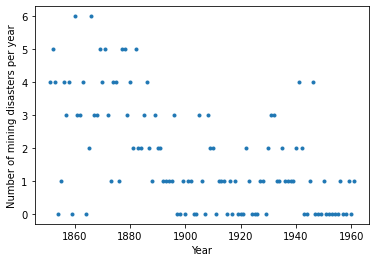

In [4]:
t = jnp.arange(coal_mining_disasters.shape[0])

time_actual = jnp.arange(1851, 1851+coal_mining_disasters.shape[0])
plt.plot(time_actual, coal_mining_disasters, '.')
plt.xlabel('Year')
plt.ylabel('Number of mining disasters per year')

Historically coal mining changed.  Can we determine Bayesian style whether something changed?


See: https://en.wikipedia.org/wiki/Generalised_logistic_function

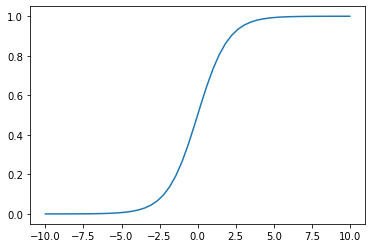

In [5]:
def sigmoid(A, K, B, M, t):
    return A+((K-A)/(1.+jnp.exp(-B*(t-M))))

x = np.linspace(-10., 10.)
plt.plot(x, sigmoid(0., 1., 1., 0, x))

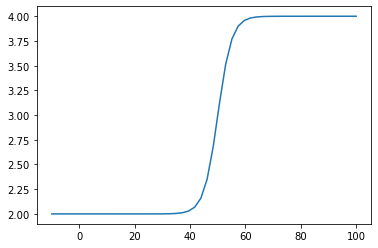

In [6]:
x = np.linspace(-10., 100.)

plt.plot(x, sigmoid(2., 4., 0.4, 50., x))

In [7]:
def probabilistic_programming_function(N, t=None, D=None):
    """why numpyro why???
    
    Such an important component of the MCMC framework in numpyro 
    and it is so poorly documented. It reminds of Tensorflow 1.0, 
    and sess.run and look what happened to tensorflow.
    
    
    However, 
    First four variables are distributions of some shape, numpyro compiles them
    
    numpyro.deterministic implies it's created deterministically from other 
    variables
    """
    rate_early = numpyro.sample("rate_early", dist.Exponential(1))
    rate_late = numpyro.sample("rate_late", dist.Exponential(1,))
    rate_scale = numpyro.sample("rate_scale", dist.HalfNormal(0.2))
    rate_change = numpyro.sample("rate_change", dist.Uniform(0, N))
    rate_t = numpyro.deterministic(
        "rate_t", 
        sigmoid(
            A=rate_early,
            K=rate_late, 
            B=rate_scale,
            M=rate_change, 
            t=t
        )
    )
    with numpyro.plate('N', N):
        numpyro.sample('obs', dist.Poisson(rate_t), obs=D)
        
    

In [8]:
nuts_kernel = NUTS(probabilistic_programming_function, adapt_step_size=True)
mcmc_model = MCMC(nuts_kernel, num_chains=1, num_warmup=1000, num_samples=4000)
rng_key = jax.random.PRNGKey(0)
mcmc_model.run(rng_key, N=len(coal_mining_disasters), t=t, D=coal_mining_disasters, extra_fields=('energy', 'potential_energy'))

sample: 100%|██████████| 5000/5000 [00:05<00:00, 996.57it/s, 7 steps of size 5.34e-01. acc. prob=0.93]  


In [9]:
mcmc_model.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  rate_change     37.53      3.41     37.62     32.37     43.11   2172.99      1.00
   rate_early      3.29      0.36      3.26      2.69      3.82   2472.25      1.00
    rate_late      0.88      0.12      0.88      0.69      1.08   2139.50      1.00
   rate_scale      0.26      0.10      0.25      0.09      0.42   2557.58      1.00

Number of divergences: 0


In [10]:
ds = az.from_numpyro(mcmc_model)

In [11]:
ds.posterior

<xarray.Dataset>
Dimensions:       (chain: 1, draw: 4000, rate_t_dim_0: 111)
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * rate_t_dim_0  (rate_t_dim_0) int64 0 1 2 3 4 5 6 ... 105 106 107 108 109 110
Data variables:
    rate_change   (chain, draw) float32 36.03 34.92 35.28 ... 35.96 33.96 38.98
    rate_early    (chain, draw) float32 3.425 3.098 3.225 ... 3.482 3.551 3.484
    rate_late     (chain, draw) float32 0.9178 1.089 1.023 ... 1.021 0.7719
    rate_scale    (chain, draw) float32 0.2274 0.2362 0.2566 ... 0.2922 0.2048
    rate_t        (chain, draw, rate_t_dim_0) float32 3.425 3.424 ... 0.7719
Attributes:
    created_at:                 2022-08-07T15:21:08.902043
    arviz_version:              0.12.1
    inference_library:          numpyro
    inference_library_version:  0.10.0

In [20]:
variables = ['rate_change', 'rate_early', 'rate_late', 'rate_scale']

array([[<AxesSubplot:ylabel='rate_early'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='rate_late'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='rate_change', ylabel='rate_scale'>,
        <AxesSubplot:xlabel='rate_early'>,
        <AxesSubplot:xlabel='rate_late'>]], dtype=object)

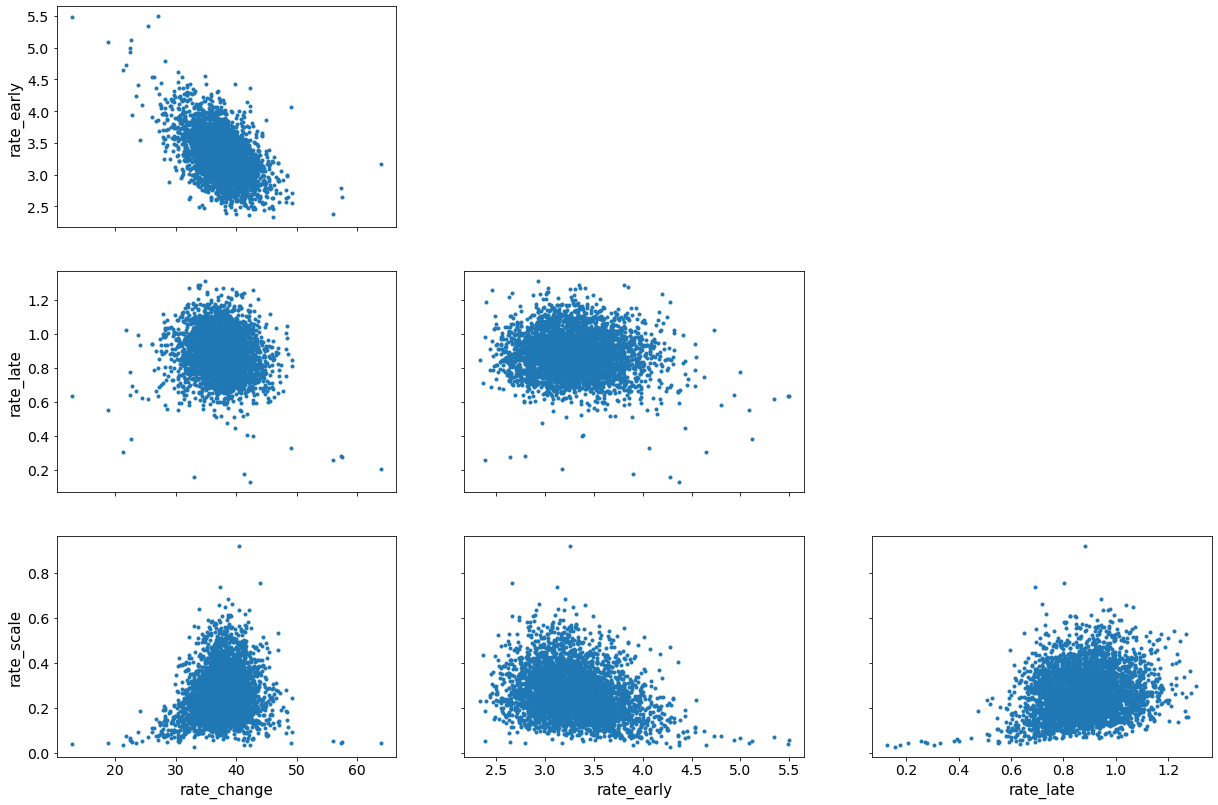

In [21]:
az.plot_pair(
    ds, 
    var_names=variables,
    divergences=True
)

array([[<AxesSubplot:title={'center':'rate_change'}>,
        <AxesSubplot:title={'center':'rate_early'}>,
        <AxesSubplot:title={'center':'rate_late'}>],
       [<AxesSubplot:title={'center':'rate_scale'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

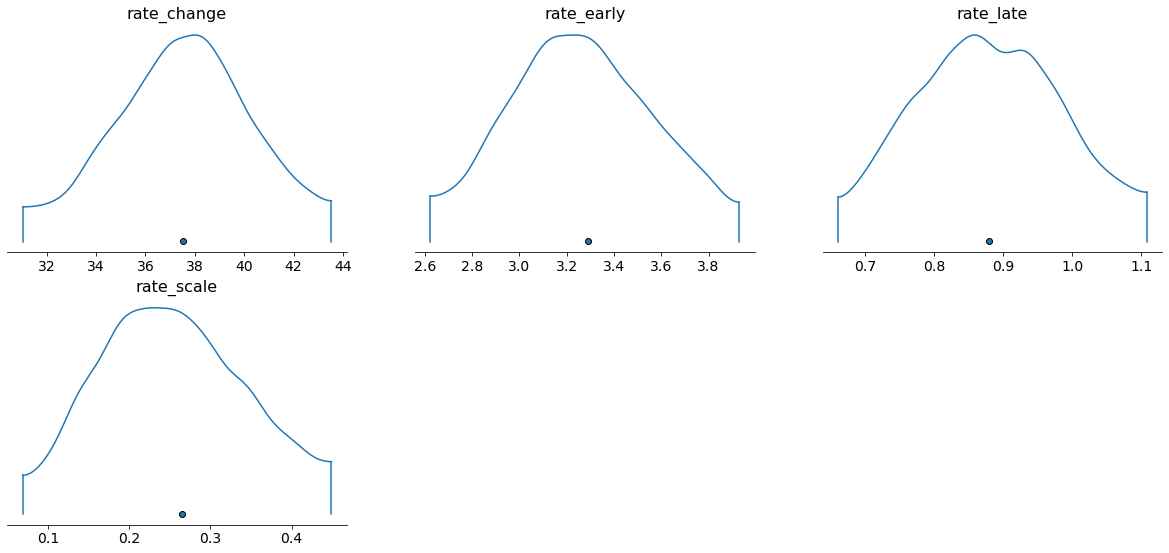

In [22]:
az.plot_density(ds.posterior, var_names=variables)

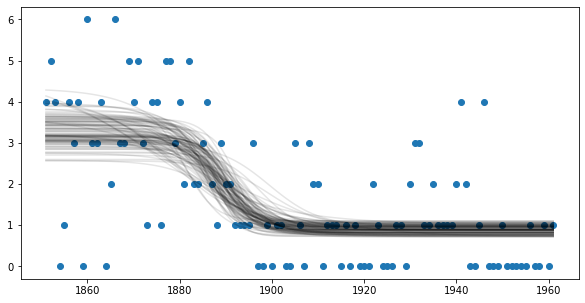

In [28]:
plt.figure(figsize=(10,5))
plt.scatter(time_actual, coal_mining_disasters)
plt.plot(time_actual, ds.posterior.rate_t[0,:100].T, color='k', alpha=0.1);

<AxesSubplot:>

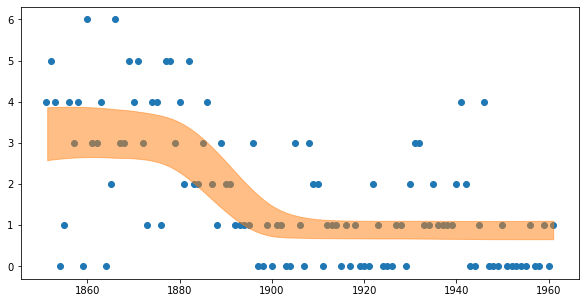

In [30]:
plt.figure(figsize=(10,5))
plt.scatter(time_actual, coal_mining_disasters)
az.plot_hdi(time_actual, ds.posterior.rate_t)

In [40]:
time_of_change = ds.posterior.rate_change+time_actual[0]



In [42]:
np.mean(time_of_change)

<xarray.DataArray 'rate_change' ()>
array(1888.53, dtype=float32)